In [27]:
#imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from lxml import etree
import os
from bs4 import BeautifulSoup
import requests
import xml.etree.ElementTree as ET
import validators
import datetime
import re
import string
import nltk
from nltk.corpus import stopwords

from collections import Counter

In [28]:
#downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('rslp')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
#parameters
characters_for_name=60
legislature='dar/01'
cycle='14'

stop_words_nltk = nltk.corpus.stopwords.words('portuguese')
#stop_words = ["the","it","she","he", "a"] #Uncomment this line if you want to use your own list of stopwords.
#The stemmers and lemmers need to be initialized before bing run
#porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('portuguese')
#wordnet = nltk.stem.WordNetLemmatizer()
#RSLP=nltk.stem.RSLPStemmer()

In [30]:
#utils

def add_zeros(int_):
    if len(str(int_))<2:
        return '00'+str(int_)
    if len(str(int_))<3:
        return '0'+str(int_)
    if len(str(int_))==3:
        return str(int_)

def get_text_from_html(url__):
    from bs4 import BeautifulSoup
    res = requests.get(url__)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    return str(soup.noscript)

def read_input_table(current_directory="C:\\Users\caperei",cycle='14',session='1' ):

    data_directory=f"\portuguese_open_data\data\cycle\{cycle}\session\{session}\\numbers_dates_pages.csv"
    input_data=pd.read_csv(r"C:\Users\caperei\portuguese_open_data\data\cyle\14\session\1\numbers_dates_pages.csv")
    return input_data

In [31]:
#regex
def check_dialog(text_):
    pat="(?:</p><p>.*?\(.*?\): —)"
    match=re.findall(pat, text_)
    if match is None :
        return 'no_dialog'
    else:
        for m in match:
            
            return m

def extract_dialog(full_text,characters_for_name):    
    if full_text is None:
        return None
    else:
        dialogs=[(m.start(0), m.end(0)) for m in re.finditer('</p><p></p><p>(.+?): —', full_text)]
        out=[]
        if len(dialogs)==1:
            out.append(full_text[dialogs[0][1]-characters_for_name:])
        if len(dialogs)>1:
            for i in range(0, len(dialogs)-1):
                out.append(full_text[dialogs[i][1]-characters_for_name:dialogs[i+1][0]])
            out.append(full_text[dialogs[len(dialogs)-1][1]-50:])
        return out

    
def extract_party_name(dialogs):
    if dialogs is None:
        return None
    else:
        res=[]
        for i in dialogs:
                    positions=[(m.start(0), m.end(0)) for m in re.finditer('\((.+?)\): —', i)]
                    if len(positions)==0:
                        res.append(['No','No'])
                    else:
                        party=re.findall('\((.+?)\)',i)
                        name_aux=i[positions[0][1]-50:positions[0][1]]
                        name=re.sub(r'\b\w{1,2}\b', '', name_aux).replace('.','').replace ('()','').replace('  ','').replace('<','').replace('>','').replace('/','').replace(': —','')
                        if len(party)>0:
                            party=party[0]
                        res.append([party,name])
        return res

def add_speech_next_page(df):
    for pi in range(1,df.page.max()+1):
        if len(df[df.page==pi].speech.values[0])>0:
            speeches=df[df.page==pi].speech.values[0]
            if '</noscript>' in speeches[-1]:
                
                for n in range(1,df.page.max()-pi):
                    if ': —' in df[df.page==pi+n].text_1.values[0]:
                        
                        in_=df[df.page==pi+n].text_1.values[0].find(': —')
                        df[df.page==pi].speech.values[0][-1]=df[df.page==pi].speech.values[0][-1]+' '+str(df[df.page==pi+n].text_1.values[0][0:in_])
                        
                        break
                    else:
                        
                        df[df.page==pi].speech.values[0][-1]=df[df.page==pi].speech.values[0][-1]+' '+str(df[df.page==pi+n].text_1.values[0])
    return df


#defining the function to remove punctuation
def remove_punctuation(text):
  if(type(text)==float):
    return text
  ans=""  
  for i in text:     
    if i not in string.punctuation:
      ans+=i    
  return ans

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
         
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

def generate_N_grams(text,ngram=1):
  words=[word for word in text]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans


def rem(x, names_deputies,parties_ ):
    ans=[]
    names_deputies=names_deputies+parties_+['sr.as','srs.','presidente','es.a','sr.ª','srº','sr']

    for i in x.split(' '):
        #print(i)
        if i not in names_deputies:
            #print(i)
            ans.append(i)

    return ' '.join(ans)

def remove_accents(raw_text):
    """Removes common accent characters.

    Our goal is to brute force login mechanisms, and I work primary with
    companies deploying Engligh-language systems. From my experience, user
    accounts tend to be created without special accented characters. This
    function tries to swap those out for standard Engligh alphabet.
    """

    raw_text = re.sub(u"[àáâãäå]", 'a', raw_text)
    raw_text = re.sub(u"[èéêë]", 'e', raw_text)
    raw_text = re.sub(u"[ìíîï]", 'i', raw_text)
    raw_text = re.sub(u"[òóôõö]", 'o', raw_text)
    raw_text = re.sub(u"[ùúûü]", 'u', raw_text)
    raw_text = re.sub(u"[ç]", 'c', raw_text)

    return raw_text

In [32]:
#functions scrapping
def build_transcripts_table_from_html(session=['01'],legislature='dar/01', cycle='14'):
    df = pd.DataFrame(columns=['legislature','cycle','session','number','date','page', 'text_1','url'])        
    #session=['01'] #['01','02','03']
    numbers_dates=list(zip(input_data.number, input_data.date,input_data.pages )) #[0:1]
    pages=input_data.pages.values #[0:1]
    s_c=[]
    n_c=[]
    d_c=[]
    p_c=[]
    u_c=[]
    t_c=[]
    for s in session:
        for number, date, page in numbers_dates:
            number=add_zeros(number)
            date=datetime.datetime.strptime(date, '%d/%m/%Y').strftime('%Y-%m-%d')
            for page_i in range(1,page+1):
                    url_=f'https://debates.parlamento.pt/catalogo/r3/{legislature}/{cycle}/{s}/{number}/{date}/{page_i}'
                    if validators.url(url_):
                        #print (url_)
                        u_c.append(url_)
                        p_c.append(page_i)
                        t_c.append(get_text_from_html(url_))
                        s_c.append(s)
                        n_c.append(number)
                        d_c.append(date)
    df['page']=p_c
    df['session']=s_c
    df['number']=n_c
    df['date']=d_c

    df['text_1']=t_c
    df['url']=u_c
    df['legislature']=legislature
    df['cycle']=cycle    
    return df

def add_party_speaker(df,characters_for_name ):
    #add columns
    df['speech']=[extract_dialog(t,characters_for_name) for t in df.text_1 ]
    df['party']=[extract_party_name(t) for t in df.speech ]
    df=add_speech_next_page(df)
    #re arrange by speaker and party
    df1=df.explode(['speech', 'party']).reset_index(drop=True)
    df2=df1.dropna(subset=['party'])
    df2['party_s']=[t[0] for t in df2.party]
    df2['speaker']=[t[1] for t in df2.party]
    df2=df2[df2.party_s!='No']
    return df2

In [33]:
#political polarization functions

right=[ 'PSD',  'CDS-PP', 'CH','IL','CDS']
left=[ 'PS', 'BE', 'PCP', 'PAN', 'PEV','L','PCP']


def create_frequency_table_grams(n_gram=1, input=None, right_parties=right, left_parties=left):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
   

    r_grams=[item for sublist in df3[df3.party_s.isin(right)][grams_d[n_gram]] for item in sublist]
    l_grams=[item for sublist in df3[df3.party_s.isin(left)][grams_d[n_gram]] for item in sublist]

    total_counter = Counter([item for sublist in df3[grams_d[n_gram]] for item in sublist])
    right_counter = Counter(r_grams)
    left_counter = Counter(l_grams)

    df_all = pd.DataFrame.from_dict(total_counter, orient='index').reset_index()
    df_all.columns=['phrase','count']
    df_all['f_right']=[right_counter[x] for x in df_all.phrase]
    df_all['f_left']=[left_counter[x] for x in df_all.phrase]


    df_all['f_left_total']=sum(left_counter.values())
    df_all['f_right_total']=sum(right_counter.values())
    df_all['f_right_minus']=(df_all['f_right']- df_all['f_right_total'])/df_all['f_right_total']
    df_all['f_left_minus']=(df_all['f_left']- df_all['f_left_total'])/df_all['f_left_total']

    df_all['f_right_norm']=df_all['f_right']/df_all['f_right_total']
    df_all['f_left_norm']=df_all['f_left']/df_all['f_left_total']

    df_all['f_right_minus_norm']=df_all['f_right_minus']/df_all['f_right_total']
    df_all['f_left_minus_norm']=df_all['f_left_minus']/df_all['f_left_total']

    return df_all


def calculate_pearson(df_all):
    aa=df_all['f_right_norm']*df_all['f_left_minus_norm'] 
    bb=df_all['f_left_norm']*df_all['f_right_minus_norm']
    cc=aa-bb
    dd=cc*cc
    d11=df_all['f_right_norm']+df_all['f_left_norm']
    d22=df_all['f_right_norm']+df_all['f_right_minus_norm']
    d33=df_all['f_left_norm']+df_all['f_left_minus_norm']
    d44=df_all['f_right_minus_norm']+df_all['f_left_minus_norm']
    denom=d11*d22*d33*d44
    pp=dd/denom
    return pp

def create_phrase_partisanship(df):
    aa=df['f_right_norm']+df['f_left_norm']
    df['rho']=df['f_right_norm']/aa
    bb=1-df['f_right_norm']
    df['f_left_norm_scaled']=df['f_right_norm']/bb
    cc=1-df['f_left_norm']
    df['f_right_norm_scaled']=df['f_left_norm']/cc
    df['pi']=df['f_right_norm']*df['rho']
    df['pi_scaled']=(df['pi']/(1-df['f_right_norm']))+((1-df['pi'])/(1-df['f_left_norm']))

    df['gram_partisanship']= 0.5 * (1 - df['pi_scaled'] + 
                           (df['f_right_norm_scaled'] +  df['f_left_norm_scaled']) * df['rho'])
    return df

def create_polarization_correlation(df):
    
    aa=df['f_left_norm']*-1
    bb= df['f_right_norm']*1
    df['beta_polarization']=aa+bb

    return df

In [34]:
input_data=read_input_table()
input_data.head(3)

,number,date,pages
0,1,25/10/2019,13
1,2,30/10/2019,124
2,3,31/10/2019,26


In [35]:
deputies=pd.read_csv(r'C:\Users\caperei\portuguese_open_data\data\cyle\14\deputados.csv', header=None)
deputies.columns=['name','party']

In [36]:
#df=build_transcripts_table_from_html()
#df.to_pickle('portuguese_transcripts_s1.pkl') 
df = pd.read_pickle('portuguese_transcripts_s1.pkl')

In [37]:
df.head()

,legislature,cycle,session,number,date,page,text_1,url,speech,party
0,dar/01,14,01,001,2019-10-25,1,"<noscript>\n<p>Sábado, 26 de outubro de 2019 ...",https://debates.parlamento.pt/catalogo/r3/dar/...,[],[]
1,dar/01,14,01,001,2019-10-25,2,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,[es.</p><p></p><p>A Sr.ª Ana Catarina Mendonça...,"[[PS, Ana Catarina Mendonça Mendes ], [No, No]..."
2,dar/01,14,01,001,2019-10-25,3,<noscript>\n<p>26 DE OUTUBRO DE 2019 </p><p>3 ...,https://debates.parlamento.pt/catalogo/r3/dar/...,"[er votado, Sr. Presidente. </p><p></p><p>O Sr...","[[No, No], [PS, Pedro Delgado Alves ]]"
3,dar/01,14,01,001,2019-10-25,4,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,[],[]
4,dar/01,14,01,001,2019-10-25,5,<noscript>\n<p>26 DE OUTUBRO DE 2019 </p><p>5 ...,https://debates.parlamento.pt/catalogo/r3/dar/...,"[residente, muito obrigado. </p><p></p><p>O Sr...","[[No, No]]"


In [38]:
df2=add_party_speaker(df,characters_for_name )

In [39]:
#remove names of deputies and parties from speech
names_deputies=[item for sublist in [sublist.split(' ') for sublist in list(map(str.lower,deputies.name.unique())) ] for item in sublist]
names_deputies=names_deputies+['eduardo', 'ferro' ,'rodrigues','presidente','secretario','duarte' ,'pacheco','noscript', 'cdspp']
parties_=[item for sublist in [sublist.split(' ') for sublist in list(map(str.lower,deputies.party.unique())) ] for item in sublist]

In [53]:
df2

,legislature,cycle,session,number,date,page,text_1,url,speech,party,party_s,speaker,speech1,tokenized_text,normalized_tokens,normalized_tokens_count,uni_grams,bi_grams,tri_grams
1,dar/01,14,01,001,2019-10-25,2,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,es.</p><p></p><p>A Sr.ª Ana Catarina Mendonça ...,"[PS, Ana Catarina Mendonça Mendes ]",PS,Ana Catarina Mendonça Mendes,esa srª mendonca — sras e srs deputados em nom...,"[esa, srª, mendonca, —, sras, e, srs, deputado...","[esa, srª, mendonca, sras, srs, deputados, nom...",76,"[esa, srª, mendonca, sras, srs, deputados, nom...","[esa srª, srª mendonca, mendonca sras, sras sr...","[esa srª mendonca, srª mendonca sras, mendonca..."
3,dar/01,14,01,001,2019-10-25,2,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,</p><p></p><p>O Sr. Secretário (Duarte Pacheco...,"[Duarte Pacheco, Secretário (Duarte Pacheco)]",Duarte Pacheco,Secretário (Duarte Pacheco),o — sras e srs deputados o projeto resolucao n...,"[o, —, sras, e, srs, deputados, o, projeto, re...","[sras, srs, deputados, projeto, resolucao, nº,...",176,"[sras, srs, deputados, projeto, resolucao, nº,...","[sras srs, srs deputados, deputados projeto, p...","[sras srs deputados, srs deputados projeto, de..."
5,dar/01,14,01,001,2019-10-25,3,<noscript>\n<p>26 DE OUTUBRO DE 2019 </p><p>3 ...,https://debates.parlamento.pt/catalogo/r3/dar/...,o. </p><p></p><p>O Sr. Pedro Delgado Alves (PS...,"[PS, Pedro Delgado Alves ]",PS,Pedro Delgado Alves,o o — sras e srs deputados passo entao a leitu...,"[o, o, —, sras, e, srs, deputados, passo, enta...","[sras, srs, deputados, passo, entao, leitura, ...",447,"[sras, srs, deputados, passo, entao, leitura, ...","[sras srs, srs deputados, deputados passo, pas...","[sras srs deputados, srs deputados passo, depu..."
8,dar/01,14,01,001,2019-10-25,6,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,cretário. </p><p></p><p>O Sr. Secretário (Duar...,"[Duarte Pacheco, Secretário (Duarte Pacheco)]",Duarte Pacheco,Secretário (Duarte Pacheco),cretario o — sras e srs deputados a ata e segu...,"[cretario, o, —, sras, e, srs, deputados, a, a...","[cretario, sras, srs, deputados, ata, seguinte...",23,"[cretario, sras, srs, deputados, ata, seguinte...","[cretario sras, sras srs, srs deputados, deput...","[cretario sras srs, sras srs deputados, srs de..."
9,dar/01,14,01,001,2019-10-25,6,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,p><p>O Sr. Presidente (Eduardo Ferro Rodrigues...,"[Eduardo Ferro Rodrigues, Presidente (Eduardo ...",Eduardo Ferro Rodrigues,Presidente (Eduardo Ferro Rodrigues),po — sras e srs deputados constitui para mim m...,"[po, —, sras, e, srs, deputados, constitui, pa...","[po, sras, srs, deputados, constitui, mim, mot...",718,"[po, sras, srs, deputados, constitui, mim, mot...","[po sras, sras srs, srs deputados, deputados c...","[po sras srs, sras srs deputados, srs deputado..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21984,dar/01,14,01,078,2020-09-10,41,<noscript>\n<p>11 DE SETEMBRO DE 2020 </p><p>4...,https://debates.parlamento.pt/catalogo/r3/dar/...,><p>41 </p><p></p><p>O Sr. João Pinho de Almei...,"[CDS-PP, João PinhoAlmeida (CDS-)]",CDS-PP,João PinhoAlmeida (CDS-),41 o joao — o senhor e que esta no governo,"[41, o, joao, —, o, senhor, e, que, esta, no, ...","[joao, senhor, governo]",3,"[joao, senhor, governo]","[joao senhor, senhor governo]",[joao senhor governo]
21986,dar/01,14,01,078,2020-09-10,41,<noscript>\n<p>11 DE SETEMBRO DE 2020 </p><p>4...,https://debates.parlamento.pt/catalogo/r3/dar/...,do PS. </p><p></p><p>O Sr. João Pinho de Almei...,"[CDS-PP, João PinhoAlmeida (CDS-)]",CDS-PP,João PinhoAlmeida (CDS-),o joao — tenha vergonha,"[o, joao, —, tenha, vergonha]","[joao, vergonha]",2,"[joao, vergonha]",[joao vergonha],[]
21989,dar/01,14,0

In [40]:
#Grams functions
df2['speech1'] = df2['speech'].str.lower()
df2['speech1']=df2['speech1'].str.replace('<p>','')
df2['speech1']=df2['speech1'].str.replace('</p>','')
df2['speech1']= df2['speech1'].apply(lambda x:remove_punctuation(x))
df2['speech1']= df2['speech1'].apply(lambda x:remove_accents(x))
df2['speech1']=df2['speech1'].apply(lambda x:rem(x, names_deputies,parties_ ) )
df2['tokenized_text'] = df2['speech1'].apply(lambda x: nltk.word_tokenize(x))
df2['normalized_tokens'] = df2['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = None))
df2['normalized_tokens_count'] = df2['normalized_tokens'].apply(lambda x: len(x))
df2['uni_grams'] = df2['normalized_tokens'].apply(lambda x: generate_N_grams(x,1))
df2['bi_grams'] = df2['normalized_tokens'].apply(lambda x: generate_N_grams(x,2))
df2['tri_grams'] = df2['normalized_tokens'].apply(lambda x: generate_N_grams(x,3))

In [41]:
#df2.party_s.unique()
parties=['PS', 'PSD', 'BE', 'PCP', 'CDS-PP', 'PAN', 'PEV','CH','IL','L','CDS']
df3=df2[df2.party_s.isin(parties)]

In [42]:
df3.head(3)

,legislature,cycle,session,number,date,page,text_1,url,speech,party,party_s,speaker,speech1,tokenized_text,normalized_tokens,normalized_tokens_count,uni_grams,bi_grams,tri_grams
1,dar/01,14,01,001,2019-10-25,2,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,es.</p><p></p><p>A Sr.ª Ana Catarina Mendonça ...,"[PS, Ana Catarina Mendonça Mendes ]",PS,Ana Catarina Mendonça Mendes,esa srª mendonca — sras e srs deputados em nom...,"[esa, srª, mendonca, —, sras, e, srs, deputado...","[esa, srª, mendonca, sras, srs, deputados, nom...",76,"[esa, srª, mendonca, sras, srs, deputados, nom...","[esa srª, srª mendonca, mendonca sras, sras sr...","[esa srª mendonca, srª mendonca sras, mendonca..."
5,dar/01,14,01,001,2019-10-25,3,<noscript>\n<p>26 DE OUTUBRO DE 2019 </p><p>3 ...,https://debates.parlamento.pt/catalogo/r3/dar/...,o. </p><p></p><p>O Sr. Pedro Delgado Alves (PS...,"[PS, Pedro Delgado Alves ]",PS,Pedro Delgado Alves,o o — sras e srs deputados passo entao a leitu...,"[o, o, —, sras, e, srs, deputados, passo, enta...","[sras, srs, deputados, passo, entao, leitura, ...",447,"[sras, srs, deputados, passo, entao, leitura, ...","[sras srs, srs deputados, deputados passo, pas...","[sras srs deputados, srs deputados passo, depu..."
12,dar/01,14,01,001,2019-10-25,8,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,</p><p>A Sr.ª Ana Catarina Mendonça Mendes (PS...,"[PS, Ana Catarina Mendonça Mendes ]",PS,Ana Catarina Mendonça Mendes,a srª mendonca — sras e srs deputados as minha...,"[a, srª, mendonca, —, sras, e, srs, deputados,...","[srª, mendonca, sras, srs, deputados, primeira...",230,"[srª, mendonca, sras, srs, deputados, primeira...","[srª mendonca, mendonca sras, sras srs, srs de...","[srª mendonca sras, mendonca sras srs, sras sr..."


In [43]:
dfg=create_frequency_table_grams(n_gram=1, input=df3, right_parties=right, left_parties=left)
dfg2=create_frequency_table_grams(n_gram=2, input=df3, right_parties=right, left_parties=left)
dfg3=create_frequency_table_grams(n_gram=3, input=df3, right_parties=right, left_parties=left)


In [44]:
dfg2.to_pickle('dfg2.pkl') 
dfg3.to_pickle('dfg3.pkl') 

In [45]:
dfg['pearson_quad']=calculate_pearson(dfg)
dfg2['pearson_quad']=calculate_pearson(dfg2)
dfg3['pearson_quad']=calculate_pearson(dfg3)

In [46]:
trigrams_table=dfg3[dfg3.pearson_quad>0]
bigrams_table=dfg2[dfg2.pearson_quad>0]
unigrams_table=dfg[dfg.pearson_quad>0]

In [47]:
unigrams_table=create_phrase_partisanship(unigrams_table)
trigrams_taunigrams_tableble=create_polarization_correlation(unigrams_table)

bigrams_table=create_phrase_partisanship(bigrams_table)
bigrams_table=create_polarization_correlation(bigrams_table)

trigrams_table=create_phrase_partisanship(trigrams_table)
trigrams_table=create_polarization_correlation(trigrams_table)

unigrams_table=unigrams_table.sort_values(by='gram_partisanship',ascending=False)
bigrams_table=bigrams_table.sort_values(by='gram_partisanship',ascending=False)
trigrams_table=trigrams_table.sort_values(by='gram_partisanship',ascending=False)

In [48]:
unigrams_table.to_csv('unigrams_table.csv')
bigrams_table.to_csv('bigrams_table.csv')
trigrams_table.to_csv('trigrams_table.csv')

In [54]:
trigrams_table

,phrase,count,f_right,f_left,f_left_total,f_right_total,f_right_minus,f_left_minus,f_right_norm,f_left_norm,f_right_minus_norm,f_left_minus_norm,pearson_quad,rho,f_left_norm_scaled,f_right_norm_scaled,pi,pi_scaled,gram_partisanship,beta_polarization
3689,bem srª cecilia,47,47,0,386023,216490,-0.999783,-1.000000,0.000217,0.000000,-0.000005,-0.000003,0.367172,1.0,0.000217,0.000000,0.000217,1.000000,0.000109,0.000217
1140,srª cecilia sras,43,43,0,386023,216490,-0.999801,-1.000000,0.000199,0.000000,-0.000005,-0.000003,0.367912,1.0,0.000199,0.000000,0.000199,1.000000,0.000099,0.000199
1141,cecilia sras srs,43,43,0,386023,216490,-0.999801,-1.000000,0.000199,0.000000,-0.000005,-0.000003,0.367912,1.0,0.000199,0.000000,0.000199,1.000000,0.000099,0.000199
89039,ado andre andre,40,40,0,386023,216490,-0.999815,-1.000000,0.000185,0.000000,-0.000005,-0.000003,0.368567,1.0,0.000185,0.000000,0.000185,1.000000,0.000092,0.000185
12245,deputado andre vou,39,39,0,386023,216490,-0.999820,-1.000000,0.000180,0.000000,-0.000005,-0.000003,0.368808,1.0,0.000180,0.000000,0.000180,1.000000,0.000090,0.000180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31462,deputada srª ines,31,0,31,386023,216490,-1.000000,-0.999920,0.000000,0.000080,-0.000005,-0.000003,0.662062,0.0,0.000000,0.000080,0.000000,1.000080,-0.000040,-0.000080
11544,grandes grupos economicos,33,0,33,386023,216490,-1.000000,-0.999915,0.000000,0.000085,-0.000005,-0.000003,0.660728,0.0,0.000000,0.000085,0.000000,1.000085,-0.000043,-0.000085
224112,voto favor todos,34,0,34,386023,216490,-1.000000,-0.999912,0.000000,0.000088,-0.000005,-0.000003,0.660122,0.0,0.000000,0.000088,0.000000,1.000088,-0.000044,-0.000088
30557,srª ines srª,38,0,38,386023,216490,-1.000000,-0.999902,0.000000,0.000098,-0.000005,-0.000003,0.658026,0.0,0.000000,0.000098,0.000000,1.000098,-0.000049,-0.000098


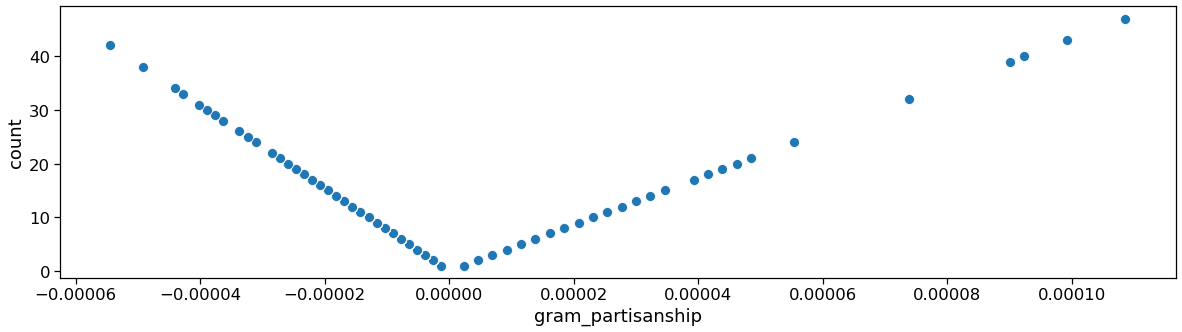

In [50]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
with sns.plotting_context("notebook",font_scale=1.5):
    sns.scatterplot(x="gram_partisanship",y='count',s=100,
                data=trigrams_table)

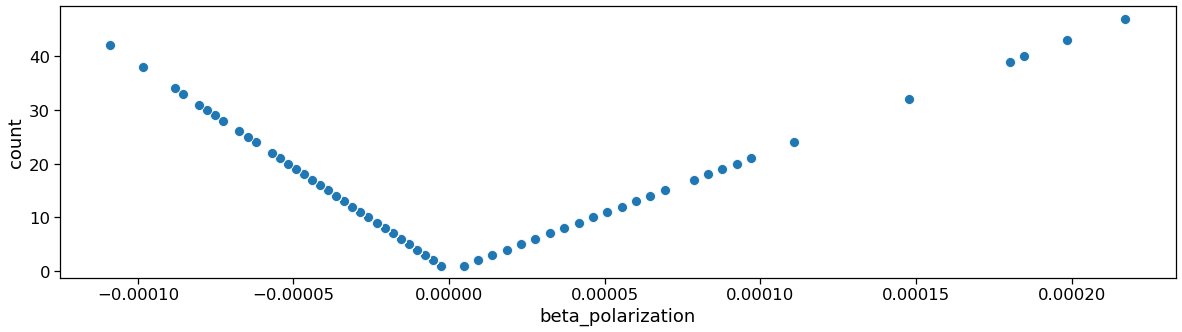

In [51]:
plt.figure(figsize=(20,5))
with sns.plotting_context("notebook",font_scale=1.5):
    sns.scatterplot(x="beta_polarization",y='count',s=100,
                data=trigrams_table)

<AxesSubplot:>

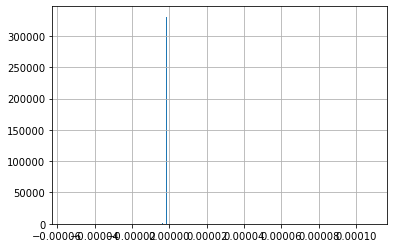

In [52]:
trigrams_table['gram_partisanship'].hist(bins = 500)